# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 3: Neural Machine Translation (30 pts)
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder (18 pts)

In [1]:
# Add utilities path
import sys
import os

path_to_utils = 'pyfiles'
sys.path.append(os.path.join(r'/home/long/Desktop/DS1011_hw2', path_to_utils))

In [2]:
# Import custom modules
import global_variables
import nmt_dataset
import nnet_models_new

PAD_IDX = global_variables.PAD_IDX;
SOS_IDX = global_variables.SOS_IDX;
EOS_IDX = global_variables.EOS_IDX;

In [3]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = r'/home/long/Desktop/DS1011_hw2'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = '/home/long/Desktop/DS1011_hw2/data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [4]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [5]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 128

In [6]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [7]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
enc_layers = 3
lr = 0.025;
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 20

#### 1.1 Encoder (9 pts)

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable

# Add transformer as encoder in seq2seq model

# code below can help you to start it, but feel free to start from scratch

class EncoderTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=MAX_LEN, dim=512, num_layers=1, nhead=2, dropout=0.0):
        super(EncoderTransformer, self).__init__()

        self.embedding = nn.Embedding(vocab_size, dim, padding_idx=PAD_IDX)
        self.position_embed = PositionalEncoding(max_len, dim,dropout=dropout)# sinusoidal embedding
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead, dim_feedforward=512, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = Norm(dim)

    def features(self, token_indices):
        x = self.embedding(token_indices)
        x = self.position_embed(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        return x

    def forward(self, text_vec):
        # some helpful directions below, check the MLM lab for more details
        # embedded = pos_embedded + embedded  # apply pos embedding
        # output = self.transformer(embedded)

        x = self.features(text_vec)
        # x = self.norm(x)
        return x.permute(1, 0, 2), x[-1].unsqueeze(0).contiguous()

# Reference: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, max_len, dim, dropout=0.0):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        self.pe = self.pe.squeeze(1)
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)


class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

#### 1.2 Decoder(s) (9 pts) Commented out for easier training reset. Codes are identical.

In [144]:
# Basic RNN decoder (no attention)
# decoder_rnn_base = nnet_models_new.DecoderRNN(target_vocab, hidden_size, enc_layers)

In [145]:
# RNN Decoder with Encoder attention
# decoder_encoder_attn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
#                                  hidden_size=hidden_size,
#                                  encoder_attention = True,
#                                  self_attention = False)

In [146]:
# RNN Decoder with Encoder & Self attention
# decoder_encoder_self_attn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
#                                  hidden_size=hidden_size,
#                                  encoder_attention = True,
#                                  self_attention = True)

#### Training & Evaluation


In [50]:
import time
from tqdm import notebook
from collections import defaultdict
import pickle

def get_full_filepath(path, enc_type):
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))

def save_param(params, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn_params.pth'
    with open(os.path.join(path, filename), 'wb') as f:
        pickle.dump(params, f)

def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):
    res = defaultdict(list)
    res['train_loss'] = list()
    # res['train_bleu'] = list()
    res['test_bleu'] = list()

    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));

        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train'])

        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        # self.criterion(scores, ys.view(-1))

        res['train_loss'].append(epoch_loss)

        sys.stdout.flush()

        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            sys.stdout.flush()

            nmt.scheduler_step(val_bleu_score);

            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type);
            # train_bleu = nmt.get_bleu_score(dataloader['train'])
            # print(train_bleu)
            # res['train_bleu'].append(train_bleu)
            res['test_bleu'].append(val_bleu_score)
            save_param(res, saved_model_path, enc_type)

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))

In [51]:
# Model 1

encoder = EncoderTransformer(vocab_size=source_vocab,
                             dim=hidden_size,
                             num_layers=1,
                             dropout=0.0)

decoder_rnn_base = nnet_models_new.DecoderRNN(target_vocab, hidden_size, 1)

nmt_encoder_base = nnet_models_new.seq2seq(encoder, decoder_rnn_base,
                              lr = lr,
                              use_cuda = use_cuda,
                              hiddensize = hidden_size,
                              numlayers = hidden_size,
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

train_model(dataloader_dict, nmt_encoder_base,
                  num_epochs = num_epochs,
                  saved_model_path = saved_models_dir,
                  enc_type = 'rnn_base')

Epoch: [0/20]

epoch 0 loss = 2.1718703562503108, time = 196.36634826660156
validation bleu:  2.034305950015089
Epoch: [1/20]

epoch 1 loss = 1.4604030185495631, time = 188.0624942779541
validation bleu:  6.83414400853248
Epoch: [2/20]

epoch 2 loss = 1.2035723732555428, time = 187.33895635604858
validation bleu:  12.252209934135191
Epoch: [3/20]

epoch 3 loss = 1.0199825368318314, time = 187.8161690235138
validation bleu:  15.869841391025961
Epoch: [4/20]

epoch 4 loss = 0.885952390639621, time = 187.09627676010132
validation bleu:  18.538282864878212
Epoch: [5/20]

epoch 5 loss = 0.7929514325074315, time = 187.56712555885315
validation bleu:  19.896717010969965
Epoch: [6/20]

epoch 6 loss = 0.7145016037942563, time = 188.66655325889587
validation bleu:  21.416720891214748
Epoch: [7/20]

epoch 7 loss = 0.6547850931799689, time = 188.72741985321045
validation bleu:  22.27402436058214
Epoch: [8/20]

epoch 8 loss = 0.599547107354351, time = 190.96555042266846
validation bleu:  23.5488844

In [18]:
# Model 2
if False:
    encoder = EncoderTransformer(vocab_size=source_vocab,
                                 dim=hidden_size,
                                 num_layers=enc_layers,
                                 dropout=0.2)

    decoder_encoder_attn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                     hidden_size=hidden_size,
                                     encoder_attention = True,
                                     self_attention = False)

    nmt_encoder_attn = nnet_models_new.seq2seq(encoder, decoder_encoder_attn,
                                  lr = lr,
                                  use_cuda = use_cuda,
                                  hiddensize = hidden_size,
                                  numlayers = hidden_size,
                                  target_lang=dataset_dict['train'].target_lang_obj,
                                  longest_label = longest_label,
                                  clip = gradient_clip)

    train_model(dataloader_dict, nmt_encoder_attn,
                      num_epochs = num_epochs,
                      saved_model_path = saved_models_dir,
                      enc_type = 'rnn_enc_attn')

Epoch: [0/20]

epoch 0 loss = 2.217679965403653, time = 340.60895347595215
validation bleu:  4.1655200996145325
Epoch: [1/20]

epoch 1 loss = 1.4310905520834136, time = 356.15379095077515
validation bleu:  11.729852987691558
Epoch: [2/20]

epoch 2 loss = 1.2060993977823395, time = 384.75046372413635
validation bleu:  16.135825111325182
Epoch: [3/20]

epoch 3 loss = 1.0826571330279606, time = 376.7724459171295
validation bleu:  19.142815754944046
Epoch: [4/20]

epoch 4 loss = 0.9978557060723289, time = 338.7891435623169
validation bleu:  21.65495906349584
Epoch: [5/20]

epoch 5 loss = 0.9380865312229887, time = 337.55385875701904
validation bleu:  23.275839004964265
Epoch: [6/20]

epoch 6 loss = 0.8863349064508018, time = 336.7770059108734
validation bleu:  24.024850637786752
Epoch: [7/20]

epoch 7 loss = 0.8476780474119936, time = 336.73713850975037
validation bleu:  25.665798864594507
Epoch: [8/20]

epoch 8 loss = 0.8137299418449402, time = 336.64025807380676
validation bleu:  26.4697

In [148]:
# Model 3
if False:
    encoder = EncoderTransformer(vocab_size=source_vocab,
                                 dim=hidden_size,
                                 num_layers=enc_layers,
                                 dropout=0.2)

    decoder_encoder_self_attn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                     hidden_size=hidden_size,
                                     encoder_attention = True,
                                     self_attention = True)

    nmt_encoder_self_attn = nnet_models_new.seq2seq(encoder, decoder_encoder_self_attn,
                                  lr = lr,
                                  use_cuda = use_cuda,
                                  hiddensize = hidden_size,
                                  numlayers = hidden_size,
                                  target_lang=dataset_dict['train'].target_lang_obj,
                                  longest_label = longest_label,
                                  clip = gradient_clip)

    train_model(dataloader_dict, nmt_encoder_self_attn,
                      num_epochs = 30,
                      saved_model_path = saved_models_dir,
                      enc_type = 'rnn_enc_self_attn')

Epoch: [0/30]

epoch 0 loss = 2.264548347241855, time = 359.1746940612793
validation bleu:  0.8652406895415017
Epoch: [1/30]

epoch 1 loss = 1.555189271767934, time = 365.01192831993103
validation bleu:  8.57213496907532
Epoch: [2/30]

epoch 2 loss = 1.2641877891745414, time = 347.5847837924957
validation bleu:  14.670874542369578
Epoch: [3/30]

epoch 3 loss = 1.125463708030557, time = 353.43466210365295
validation bleu:  17.556752251477878
Epoch: [4/30]

epoch 4 loss = 1.0389911518540493, time = 371.1988022327423
validation bleu:  19.97868527203525
Epoch: [5/30]

epoch 5 loss = 0.9725675977609747, time = 373.96377778053284
validation bleu:  22.065236711231027
Epoch: [6/30]

epoch 6 loss = 0.9291917672453001, time = 356.344366312027
validation bleu:  23.29961642228481
Epoch: [7/30]

epoch 7 loss = 0.8854990571836301, time = 344.39176774024963
validation bleu:  24.06076019112248
Epoch: [8/30]

epoch 8 loss = 0.8546912824592717, time = 352.2975308895111
validation bleu:  24.5374089701215

In [52]:
def plot_curves(loss, bleu, model_name):
    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()
    epochs = np.array(list(range(len(loss))))
    ax1.plot(epochs, loss, label='Train loss',color = 'b')
    ax1.set_ylabel('Train loss')

    ax1.legend(loc='lower center')
    ax2 = ax1.twinx()
    ax2.plot(epochs,bleu,label = 'Val BLEU',color = 'r')
    ax2.set_ylabel('Val BLEU')
    ax2.legend(loc='upper center')
    plt.title('Training loss and validation BLEU curves for {}'.format(model_name))
    plt.show()

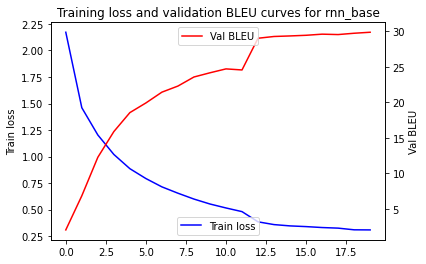

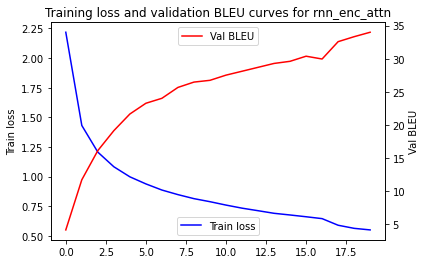

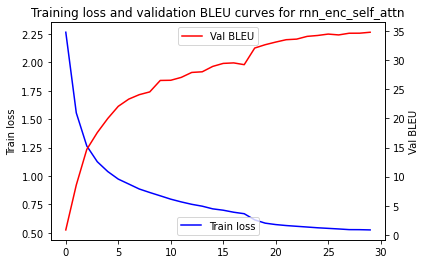

In [54]:
model_name = 'rnn_base'
temp = pickle.load(open('/home/long/Desktop/DS1011_hw2/en2fr/nmt_enc_{}_dec_rnn_params.pth'.format(model_name), 'rb'))
plot_curves(temp['train_loss'], temp['test_bleu'], model_name)

model_name = 'rnn_enc_attn'
temp = pickle.load(open('/home/long/Desktop/DS1011_hw2/en2fr/nmt_enc_{}_dec_rnn_params.pth'.format(model_name), 'rb'))
plot_curves(temp['train_loss'], temp['test_bleu'], model_name)

model_name = 'rnn_enc_self_attn'
temp = pickle.load(open('/home/long/Desktop/DS1011_hw2/en2fr/nmt_enc_{}_dec_rnn_params.pth'.format(model_name), 'rb'))
plot_curves(temp['train_loss'], temp['test_bleu'], model_name)

---
### 2 Attention visualization (12 pts)

In [ ]:
# Model was trained in ~2 hours, i.e. you can expect attention maps
# to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [66]:
from googletrans import Translator
translator = Translator()

import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def get_binned_bl_score(nmt_model, val_dataset):

#     source_len = np.sort(np.array(val_dataset.main_df['source_len']))
#     len_threshold = [0]+[source_len[x*1000+376] for x in range(1, 21)];
#     len_threshold = np.unique(len_threshold)
    len_threshold = np.arange(0, 31, 5)
    bin_bl_score = np.zeros(len(len_threshold));

    for i in notebook.tqdm(range(1, len(len_threshold)), total = len(len_threshold)-1):
        min_len = len_threshold[i-1]
#         min_len = 0
        max_len = len_threshold[i]

        temp_dataset = copy.deepcopy(val_dataset);
        temp_dataset.main_df = temp_dataset.main_df[(temp_dataset.main_df['source_len'] > min_len) & (temp_dataset.main_df['source_len'] <= max_len)];
        temp_loader = DataLoader(temp_dataset, batch_size = batchSize,
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=100),
                            shuffle = True, num_workers=0)

        bin_bl_score[i] = nmt_model.get_bleu_score(temp_loader);


    len_threshold = len_threshold[1:]
    bin_bl_score = bin_bl_score[1:]

    plt.plot(len_threshold, bin_bl_score, 'x-')
    plt.ylim(0, np.max(bin_bl_score)+1)
    plt.xlabel('len')
    plt.ylabel('bl score')

    return len_threshold, bin_bl_score

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""

    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)

    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');

    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device),
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('source: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    print('GT on sentence (src->tgt): ', translator.translate(sentence,
                                                     src = source_name,
                                                     dest = target_name).text)

    print('GT on prediction (tgt->src): ', translator.translate(prediction,
                                                     src = target_name,
                                                     dest = source_name).text)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [78]:
# Model 1
nmt_encoder_base = torch.load(get_full_filepath(saved_models_dir, 'rnn_base'))

print('=' * 75)
get_translation(nmt_encoder_base, 'business expenses are tax deductible .', source_lang_obj, use_cuda)
print('=' * 75)
get_translation(nmt_encoder_base, 'is this correct ?', source_lang_obj, use_cuda)
print('=' * 75)
get_translation(nmt_encoder_base, 'promise me you ll be careful .', source_lang_obj, use_cuda)
print('=' * 75)

source:  business expenses are tax deductible .
prediction:  ces noms se sont les cheveux .
GT on sentence (src->tgt):  frais professionnels sont déductibles d'impôt.
GT on prediction (tgt->src):  these names have hair.
source:  is this correct ?
prediction:  est ce la ?
GT on sentence (src->tgt):  est-ce correct ?
GT on prediction (tgt->src):  is what the?
source:  promise me you ll be careful .
prediction:  promettez moi que vous ne serez pas prudent .
GT on sentence (src->tgt):  Promets-moi que vous serez prudent.
GT on prediction (tgt->src):  promise me that you will not be careful.


source:  business expenses are tax deductible .
prediction:  les affaires de tout le monde sont les aliments que les autres sont des animaux .
GT on sentence (src->tgt):  frais professionnels sont déductibles d'impôt.
GT on prediction (tgt->src):  the business of everyone are the foods that others are animals.
source:  is this correct ?
prediction:  ce n est pas juste ce tableau ?
GT on sentence (src->tgt):  est-ce correct ?
GT on prediction (tgt->src):  this is not just the picture?
source:  promise me you ll be careful .
prediction:  promets moi que tu seras prudent !
GT on sentence (src->tgt):  Promets-moi que vous serez prudent.
GT on prediction (tgt->src):  promise me you'll be careful!


<ipython-input-66-8c74b2a809ba>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-66-8c74b2a809ba>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ')+


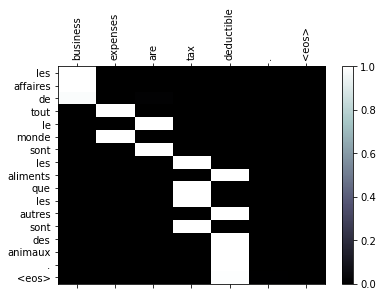

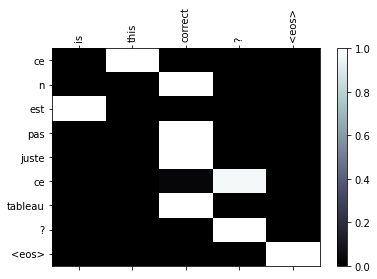

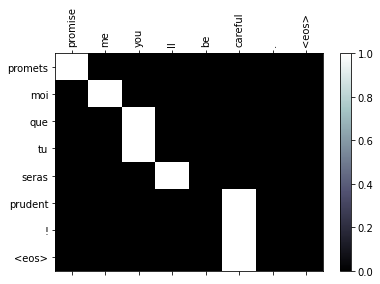

In [76]:
# Model 2
nmt_encoder_enc_attn = torch.load(get_full_filepath(saved_models_dir, 'rnn_enc_attn'))

print('=' * 75)
get_translation(nmt_encoder_enc_attn, 'business expenses are tax deductible .', source_lang_obj, use_cuda)
print('=' * 75)
get_translation(nmt_encoder_enc_attn, 'is this correct ?', source_lang_obj, use_cuda)
print('=' * 75)
get_translation(nmt_encoder_enc_attn, 'promise me you ll be careful .', source_lang_obj, use_cuda)
print('=' * 75)

source:  business expenses are tax deductible .
prediction:  les affaires sont des faits de la population .
GT on sentence (src->tgt):  frais professionnels sont déductibles d'impôt.
GT on prediction (tgt->src):  business are facts of the population.
source:  is this correct ?
prediction:  est ce que c est que ce que le spectacle est en train de se faire du souci ?
GT on sentence (src->tgt):  est-ce correct ?
GT on prediction (tgt->src):  is what it is what the show is about to be worried?
source:  promise me you ll be careful .
prediction:  promets moi que tu seras prudente !
GT on sentence (src->tgt):  Promets-moi que vous serez prudent.
GT on prediction (tgt->src):  promise me you'll be careful!


<ipython-input-66-8c74b2a809ba>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-66-8c74b2a809ba>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ')+


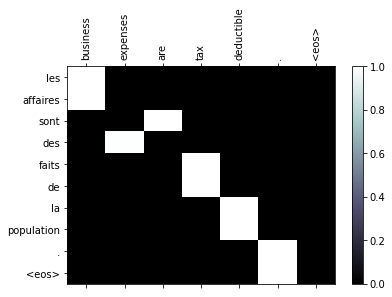

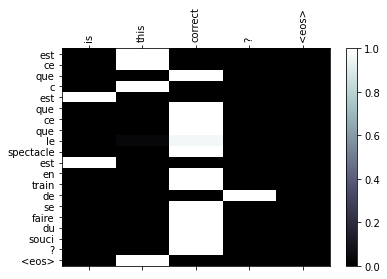

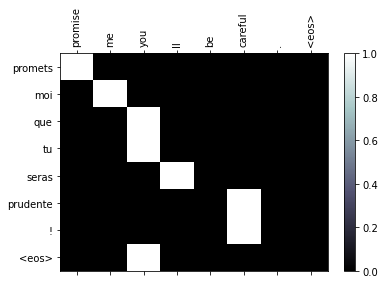

In [77]:
# Model 3
nmt_encoder_enc_self_attn = torch.load(get_full_filepath(saved_models_dir, 'rnn_enc_self_attn'))

print('=' * 75)
get_translation(nmt_encoder_enc_self_attn, 'business expenses are tax deductible .', source_lang_obj, use_cuda)
print('=' * 75)
get_translation(nmt_encoder_enc_self_attn, 'is this correct ?', source_lang_obj, use_cuda)
print('=' * 75)
get_translation(nmt_encoder_enc_self_attn, 'promise me you ll be careful .', source_lang_obj, use_cuda)
print('=' * 75)